# 4. CAD Feature Recognition and Manufacturing Process Selection through VQA Multimodal LLM Models

Project Objective:
- Evaluate the performance of various state-of-the-art visual question answering (VQA) models on CAD images.
- Assess these models' capabilities in **recognizing features** and **selecting appropriate high-level manufacturing processes**.
- Design **effective prompts** to determine the **most suitable manufacturing process** for the parts depicted in the CAD images.

### Notebook 4. Performance evaluation on Llava_1.6 model


- Author: [Chen Lequn](https://www.linkedin.com/in/lequn-chen-433040159)

In [1]:
import torch
import json
import os, sys, requests, argparse

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
import gc
gc.collect()

0

In [4]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

### Helper functions

In [5]:
def save_response_to_json(response, filename):
    try:
        response_dict = json.loads(response)
        with open(filename, 'w') as file:
            json.dump(response_dict, file, indent=2)
        print(f"Response saved to {filename}")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")

In [40]:
import json

# Function to extract the response JSON after the prompt
def extract_response_json(response):
    try:
        # Split the response string by the end of the instruction marker
        parts = response.split("[/INST]")
        
        if len(parts) < 2:
            print("End of instruction marker [/INST] not found")
            return None
        
        # The response JSON should be in the last part
        json_str = parts[-1].strip()
        
        # Find the first JSON object in the extracted part
        start_pos = json_str.find("{")
        end_pos = json_str.rfind("}")

        if start_pos == -1 or end_pos == -1:
            print("No valid JSON found in the response")
            return None

        json_str = json_str[start_pos:end_pos+1]
        
        return json_str
    except Exception as e:
        print(f"Error extracting JSON from response: {e}")
        return None

# Function to post-process the response
def post_process_response(response):
    try:
        # Extract the JSON string
        json_str = extract_response_json(response)
        if not json_str:
            return None
        
        response_dict = json.loads(json_str)
        print("Successfully decoded JSON")
        
        # Consolidate features that exist
        consolidated_features = [feature for feature in response_dict['identified_features'] if feature['exists']]
        print(f"Consolidated Features: {consolidated_features}")
        
        return json.dumps({"identified_features": consolidated_features}, indent=2)
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON response: {e}")
        return None

In [7]:
Result_dir = os.path.join('..', 'Results')

### Specify Cache Directory

In [8]:
# Windows: cache_dir="D:\.cache\huggingface"
# Ubuntu linux (Lequn): cache_dir="/home/chenlequn/pan1/.cache/huggingface"
# Ubuntu linux (Khan): cache_dir="/home/chenlequn/pan1/.cache/huggingface"

CACHE_DIR = "/home/chenlequn/pan1/.cache/huggingface"

## Loading the visual LLM models

### llava-hf/llava-v1.6-mistral-7b-hf

- Website: https://llava-vl.github.io/blog/2024-01-30-llava-next/ (Jan 2024)
- Model: https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf
- LLaVa combines a pre-trained large language model with a pre-trained vision encoder for multimodal chatbot use cases. LLaVA 1.6 improves on LLaVA 1.5 BY:
    - Using `Mistral-7B `(for this checkpoint) and `Nous-Hermes-2-Yi-34B` which has better commercial licenses, and bilingual support
    - More diverse and high quality data mixture
    - Dynamic high resolution

- Prompt templete
```
"[INST] <image>\nWhat is shown in this image? [/INST]"
```

#### Load the pretrained model with tokenizer

In [9]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig

llava_hf_mistral_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", cache_dir=CACHE_DIR)

# Step 1: Define the BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # You can set this to True or False depending on your requirement
    load_in_8bit=False, # Set this to False if you're using 4-bit quantization
    # bnb_4bit_use_double_quant=True,  # Optional: Fine-tune the quantization behavior
    # bnb_4bit_quant_type="nf4",       # Optional: Choose quantization type, e.g., "nf4" or "fp4"
    # bnb_4bit_compute_dtype="float16",  # Optional: Set compute dtype, e.g., "float16"
    # llm_int8_enable_fp32_cpu_offload = True, #  split your model in different parts and run some parts in int8 on GPU and some parts in fp32 on CPU, This is useful for offloading large models such as google/flan-t5-xxl.
)


llava_hf_mistral_model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    cache_dir=CACHE_DIR)

llava_hf_mistral_model.to(DEVICE)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): Q

## Performance Testing

### Define the location of the images from various testing case:

In [10]:
# # Define the relative path to the Test_Cases_STEP_Images folder
# IMAGE_PATH = os.path.join('..', 'Test_Cases_STEP_Images')


# # Criteria: 
# # The part has only 1-2 features types (i.e., normally Machining or Extrusion features)
# # No challenging features such as Sheet Metal Features. 
# # All the features can be clearly seen by human.
# easy_test_case = ["easy_1",
#                   "easy_2",
#                   "easy_3",
#                   "easy_4",
#                   "easy_5",
#                   "easy_6",
#                   "easy_7",
#                   "easy_8",
#                   "easy_9",
#                   "easy_10",
#                   "easy_11",
#                   "easy_12",
#                   "easy_13",
#                   "easy_14",
#                   "easy_15",
#                   "easy_16",
#                   "easy_17"
#                  ]


# # Criteria: 
# # Everything in between easy and hard.
# # Moderate number of features types (>=2), 
# # Does not contain challenging feature such as sheet metal features.
# middle_test_case = ["medium_1",
#                     "medium_2",
#                     "medium_3",
#                     "medium_4",
#                     "medium_5",
#                     "medium_6",
#                     "medium_7",
#                     "medium_8",
#                     "medium_9",
#                     "medium_10",
#                     "medium_11",
#                     "medium_12",
#                     "medium_13",
#                     "medium_14",
#                     "medium_15",
#                     "medium_16",
#                     "medium_17",
#                     "medium_18",
#                     "medium_19",
#                     "medium_20"
#                    ]


# # Criteria: 
# # Extremely complex features. Many feature types, or many qunatity.
# # Difficult to predict by human without domain expertise. 
# # Mostly Real-life parts.
# challenging_test_case = ["hard_1",
#                          "hard_2",
#                          "hard_3",
#                          "hard_4",
#                          "hard_5",
#                          "hard_6",
#                          "hard_7",
#                          "hard_8",
#                          "hard_9",
#                          "hard_10",
#                          "hard_11",
#                          "hard_12",
#                          "hard_13",
#                          "hard_14",
#                          "hard_15"
#                         ]


# All_test_cases = easy_test_case + middle_test_case + challenging_test_case


# test_cases = ["easy_1",
#               "easy_2",
#               "easy_3",
#               "easy_4",
#               "easy_5",
#               "easy_6",
#               "easy_7",
#               "medium_1",
#               "medium_2",
#               "medium_3",
#               "medium_4",
#               "medium_5",
#               "hard_1",
#               "hard_2",
#               "hard_3"]


# print (len(test_cases), len(easy_test_case), len(middle_test_case), len(challenging_test_case), len(All_test_cases))



In [11]:
# Define the relative path to the Test_Cases_STEP_Images folder
IMAGE_PATH = os.path.join('..', 'Test_Cases_STEP_Images_2')


# Criteria: 
# The part has only 1-2 features types (i.e., normally Machining or Extrusion features)
# No challenging features such as Sheet Metal Features. 
# All the features can be clearly seen by human.
easy_test_case = ["easy_2",
                  "easy_13",
                  "easy_18",
                  "easy_19",
                  "easy_20",
                  "easy_21",
                  "easy_22",
                  "easy_23",
                  "easy_24",
                  "easy_25",
                  "easy_26",
                  "easy_27",
                  "easy_28",
                  "easy_29",
                  "easy_30",
                  "easy_31",
                  "easy_32",
                  "easy_33"
                 ]


# Criteria: 
# Everything in between easy and hard.
# Moderate number of features types (>=2), 
# Does not contain challenging feature such as sheet metal features.
middle_test_case = ["medium_9",
                    "medium_12",
                    "medium_21",
                    "medium_22",
                    "medium_23",
                    "medium_24",
                    "medium_25",
                    "medium_26",
                    "medium_27",
                    "medium_28",
                    "medium_29",
                    "medium_30",
                    "medium_31",
                    "medium_32",
                    "medium_33"
                   ]


# Criteria: 
# Extremely complex features. Many feature types, or many qunatity.
# Difficult to predict by human without domain expertise. 
# Mostly Real-life parts.
challenging_test_case = ["hard_6",
                         "hard_11",
                         "hard_13",
                         "hard_16",
                         "hard_17",
                         "hard_18",
                         "hard_19",
                         "hard_20",
                         "hard_21",
                         "hard_22",
                         "hard_23",
                         "hard_24",
                         "hard_25",
                         "hard_26",
                         "hard_27",
                         "hard_28",
                         "hard_29",
                         "hard_30",
                         "hard_31",
                         "hard_32",
                         "hard_33",
                         "hard_34"
                        ]


All_test_cases = easy_test_case + middle_test_case + challenging_test_case


test_cases = ["easy_18",
              "easy_22",
              "easy_27",
              "easy_30",
              "easy_33",
              "medium_21",
              "medium_23",
              "medium_26",
              "medium_29",
              "medium_32",
              "hard_16",
              "hard_20",
              "hard_24",
              "hard_31",
              "hard_34"
             ]


print (len(test_cases), len(easy_test_case), len(middle_test_case), len(challenging_test_case), len(All_test_cases))

15 18 15 22 55


In [12]:
# Dictionary to store loaded images
loaded_images = {}

# Load all images
for test_case in All_test_cases:
    img_path = os.path.join(IMAGE_PATH, test_case + "_view_1.png")
    try:
        img = Image.open(img_path).convert('RGB')
        loaded_images[test_case] = img
        print(f"Loaded image for {test_case}")
    except FileNotFoundError:
        print(f"Image for {test_case} not found at path: {img_path}")

# Example: Accessing an image from the dictionary
# img_1 = loaded_images["Part1"]

Loaded image for easy_2
Loaded image for easy_13
Loaded image for easy_18
Loaded image for easy_19
Loaded image for easy_20
Loaded image for easy_21
Loaded image for easy_22
Loaded image for easy_23
Loaded image for easy_24
Loaded image for easy_25
Loaded image for easy_26
Loaded image for easy_27
Loaded image for easy_28
Loaded image for easy_29
Loaded image for easy_30
Loaded image for easy_31
Loaded image for easy_32
Loaded image for easy_33
Loaded image for medium_9
Loaded image for medium_12
Loaded image for medium_21
Loaded image for medium_22
Loaded image for medium_23
Loaded image for medium_24
Loaded image for medium_25
Loaded image for medium_26
Loaded image for medium_27
Loaded image for medium_28
Loaded image for medium_29
Loaded image for medium_30
Loaded image for medium_31
Loaded image for medium_32
Loaded image for medium_33
Loaded image for hard_6
Loaded image for hard_11
Loaded image for hard_13
Loaded image for hard_16
Loaded image for hard_17
Loaded image for hard_1

In [13]:
# Define the target size (width, height)
target_size = (224, 224)  # Example size, adjust as needed

def resize_image(image, size):
    return image.resize(size, Image.Resampling.LANCZOS)

In [14]:
single_image_test_case = loaded_images["easy_22"]
type(single_image_test_case)

PIL.Image.Image

In [15]:
# New dictionary to store all loaded images for each part
all_loaded_images = {}

# Load all images
for test_case in All_test_cases:
    images = []
    views = ['view_1', 'view_2', 'view_3']
    for view in views:
        img_path = os.path.join(IMAGE_PATH, f"{test_case}_{view}.png")
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            images.append(img)
            print(f"Loaded {view} image for {test_case}")

    if images:
        all_loaded_images[test_case] = images

Loaded view_1 image for easy_2
Loaded view_2 image for easy_2
Loaded view_3 image for easy_2
Loaded view_1 image for easy_13
Loaded view_2 image for easy_13
Loaded view_3 image for easy_13
Loaded view_1 image for easy_18
Loaded view_2 image for easy_18
Loaded view_3 image for easy_18
Loaded view_1 image for easy_19
Loaded view_2 image for easy_19
Loaded view_3 image for easy_19
Loaded view_1 image for easy_20
Loaded view_2 image for easy_20
Loaded view_3 image for easy_20
Loaded view_1 image for easy_21
Loaded view_2 image for easy_21
Loaded view_3 image for easy_21
Loaded view_1 image for easy_22
Loaded view_2 image for easy_22
Loaded view_3 image for easy_22
Loaded view_1 image for easy_23
Loaded view_2 image for easy_23
Loaded view_3 image for easy_23
Loaded view_1 image for easy_24
Loaded view_2 image for easy_24
Loaded view_3 image for easy_24
Loaded view_1 image for easy_25
Loaded view_2 image for easy_25
Loaded view_3 image for easy_25
Loaded view_1 image for easy_26
Loaded view

In [16]:
# Concatenate images for each test case
output_dir = os.path.join(IMAGE_PATH, 'concatenated')
os.makedirs(output_dir, exist_ok=True)

In [17]:
concatenated_images = {}

# Load all images
for test_case in All_test_cases:
    img_path = os.path.join(output_dir, test_case + "_multi-view.png")
    try:
        img = Image.open(img_path).convert('RGB')
        concatenated_images[test_case] = img
        print(f"Loaded image for {test_case}")
    except FileNotFoundError:
        print(f"Image for {test_case} not found at path: {img_path}")

# Example: Accessing an image from the dictionary
# img_1 = loaded_images["Part1"]

Loaded image for easy_2
Loaded image for easy_13
Loaded image for easy_18
Loaded image for easy_19
Loaded image for easy_20
Loaded image for easy_21
Loaded image for easy_22
Loaded image for easy_23
Loaded image for easy_24
Loaded image for easy_25
Loaded image for easy_26
Loaded image for easy_27
Loaded image for easy_28
Loaded image for easy_29
Loaded image for easy_30
Loaded image for easy_31
Loaded image for easy_32
Loaded image for easy_33
Loaded image for medium_9
Loaded image for medium_12
Loaded image for medium_21
Loaded image for medium_22
Loaded image for medium_23
Loaded image for medium_24
Loaded image for medium_25
Loaded image for medium_26
Loaded image for medium_27
Loaded image for medium_28
Loaded image for medium_29
Loaded image for medium_30
Loaded image for medium_31
Loaded image for medium_32
Loaded image for medium_33
Loaded image for hard_6
Loaded image for hard_11
Loaded image for hard_13
Loaded image for hard_16
Loaded image for hard_17
Loaded image for hard_1

In [18]:
# Load few-shot examples
few_shot_image_folder = os.path.join(".", "few_shot_example")
os.makedirs(few_shot_image_folder, exist_ok=True)

few_shot_examples = []

example_images = [os.path.join(few_shot_image_folder, f) for f in os.listdir(few_shot_image_folder) if f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.jpg')]
# Process each STEP file
for images_path in example_images:
    try:
        img = Image.open(images_path).convert('RGB')
        resized_img = resize_image(img, (1024, 768))
        few_shot_examples.append(resized_img)
        print(f"Loaded image for {images_path}")
    except FileNotFoundError:
        print(f"Image for {images_path} not found at path")

Loaded image for ./few_shot_example/example_1.jpeg


/home/chenlequn/anaconda3/envs/LLM/lib/python3.10/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (135419040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Loaded image for ./few_shot_example/example_3.png
Loaded image for ./few_shot_example/example_2.png


(1024, 768)


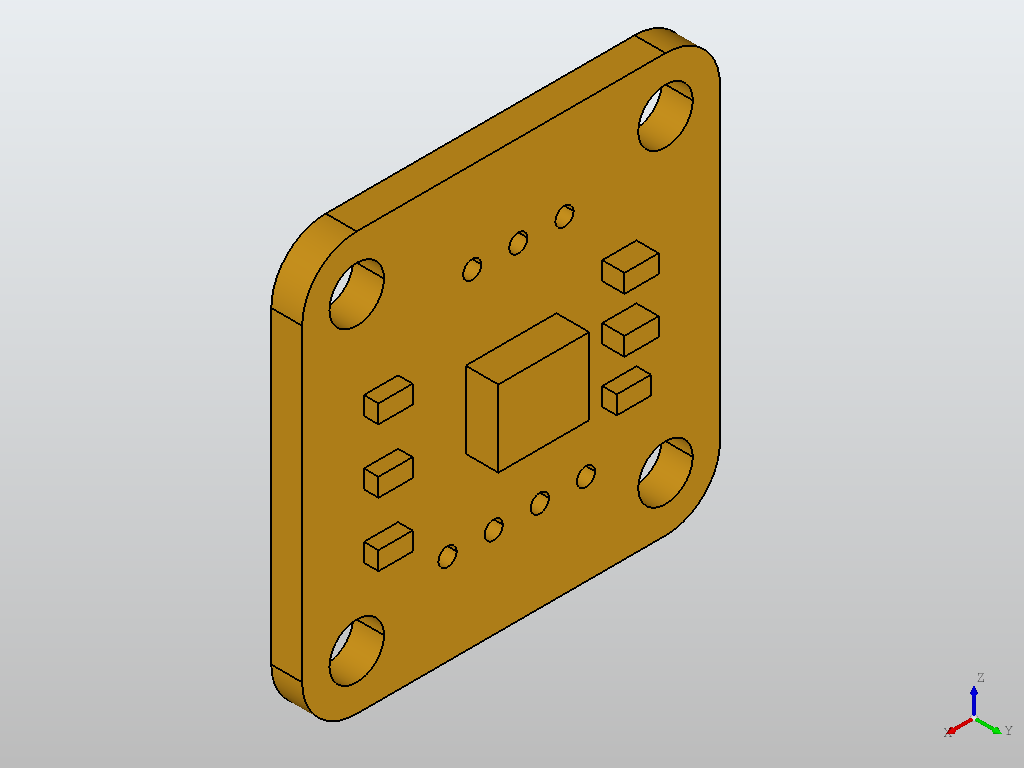

In [19]:
print (all_loaded_images["hard_25"][0].size)
all_loaded_images["hard_25"][0]

(3072, 768)


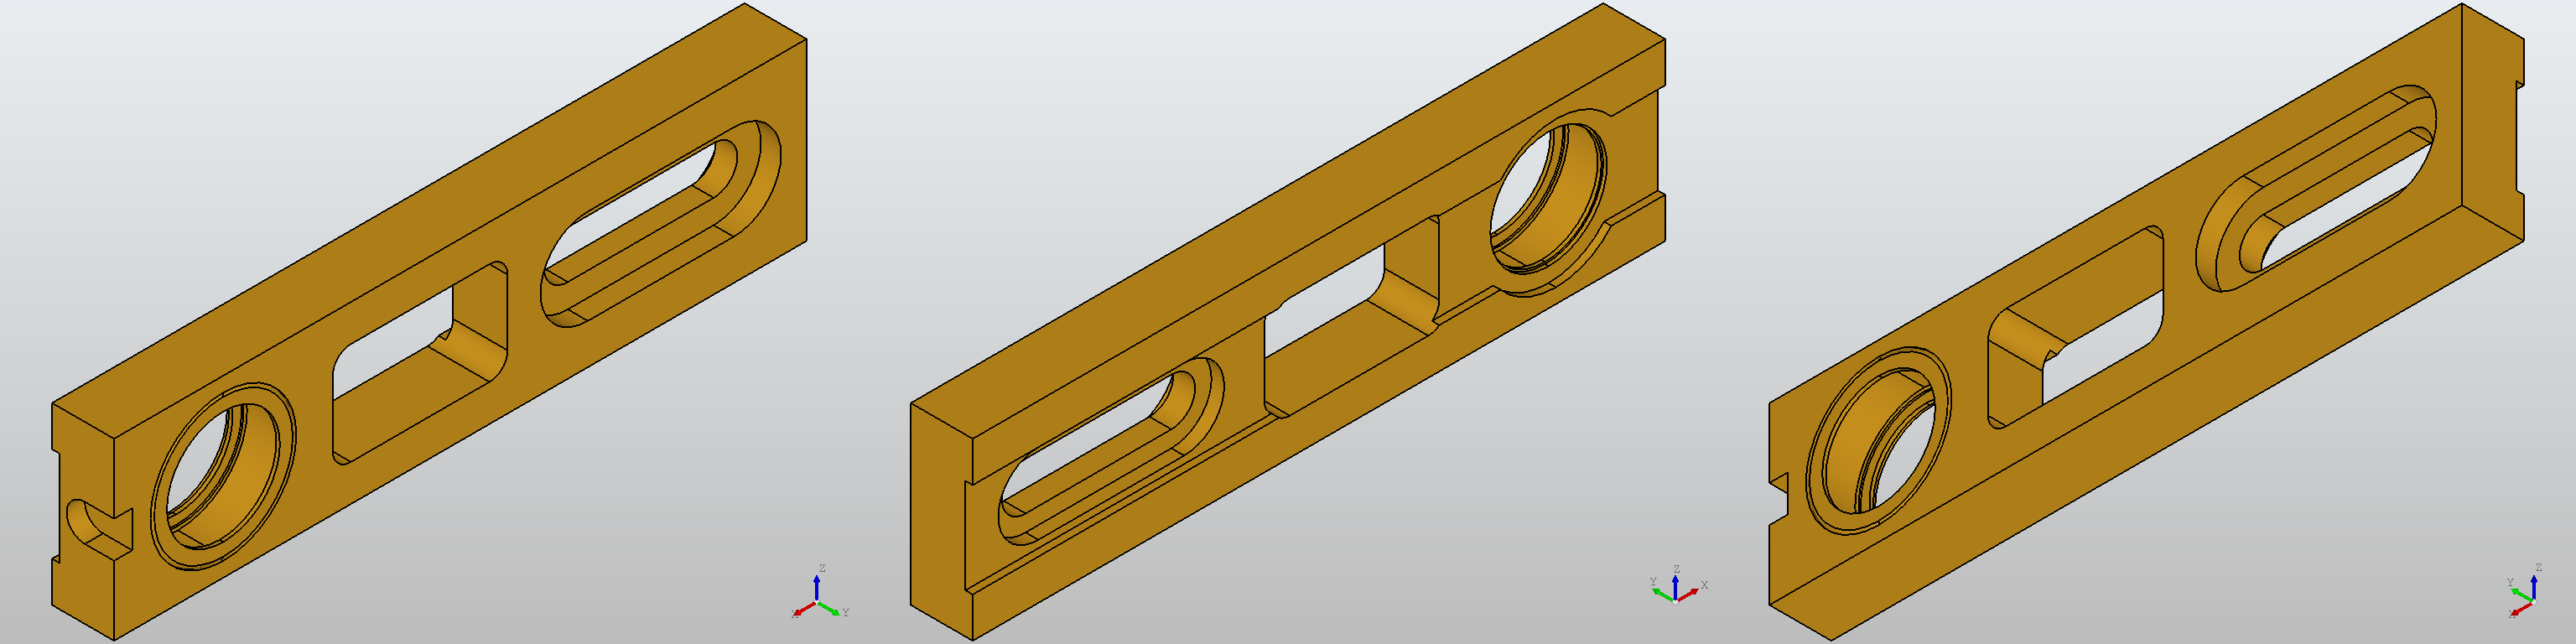

In [20]:
print (concatenated_images["hard_30"].size)
concatenated_images["hard_30"]

(1024, 768)


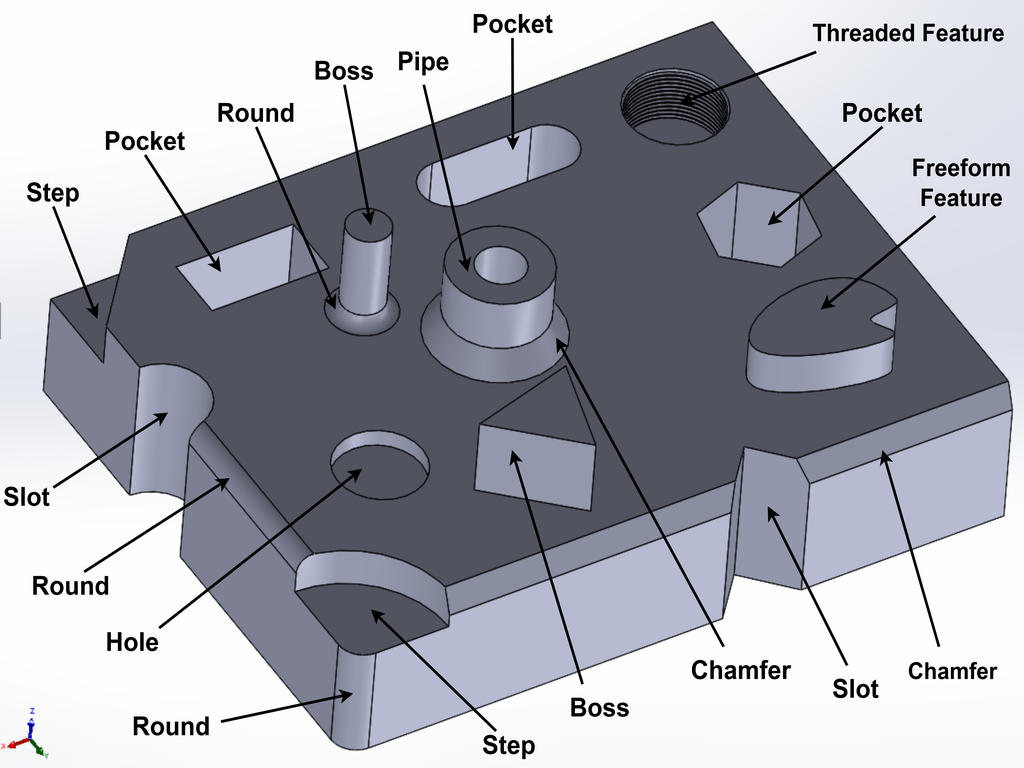

In [21]:
print (few_shot_examples[2].size)
few_shot_examples[2]

#### Grounding

two distinct types of prompts for ***CAD feature recognition*** and ***manufacturing process selection*** using a VQA LLM model:

In [22]:
# Define the relative path to the generated_images folder
JSON_FILES_PATH = os.path.join('..', 'JSON_Files')
# File names
feature_list_file = 'Manufacturing_Feature_List_Selected.json'
process_list_file = 'Manufacturing_Process_List_Selected.json'

# Full paths
feature_list_path = os.path.join(JSON_FILES_PATH, feature_list_file)
process_list_path = os.path.join(JSON_FILES_PATH, process_list_file)

# Function to read JSON file
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Read the JSON files
manufacturing_features = read_json_file(feature_list_path)
manufacturing_processes = read_json_file(process_list_path)

# Print to verify
print(json.dumps(manufacturing_features, indent=2))
print(json.dumps(manufacturing_processes, indent=2))

{
  "Manufacturing Features": {
    "Machining Features": {
      "Hole (Through / Blind Hole)": [],
      "Slot (Through / Blind / T-Slot / Dovetail)": [],
      "Step (Through / Blind Step)": [],
      "Pocket (Blind / Through / Circular End Pocket)": [],
      "Edges & Contours": {
        "Chamfer / Bevel (Sharp Edge)": [],
        "Fillet / Round (Concave / Convex)": []
      },
      "Threads & Spirals": {
        "Threaded Feature": [],
        "Gear Teeth": []
      },
      "Additional Machining Features": {
        "Neck": []
      }
    },
    "Extrusion Features": {
      "Pipe / Tube": [],
      "Boss (Circular / Obround / Irregular / Rectangular, etc)": []
    },
    "Freeform Features (Depression, Protrusion)": [],
    "Molding & Casting Features": {
      "Rib": [],
      "Gusset": [],
      "Draft": []
    },
    "Sheet Metal Features": []
  }
}
{
  "Manufacturing Processes": {
    "Additive Manufacturing": {
      "Directed Energy Deposition": [],
      "Powder Bed Fu

In [23]:
# Function to extract hierarchy
def extract_hierarchy(dictionary, current_path=""):
    result = []
    for key, value in dictionary.items():
        new_path = f"{current_path} > {key}" if current_path else key
        if isinstance(value, dict):
            result.extend(extract_hierarchy(value, new_path))
        elif isinstance(value, list) and not value:
            result.append({
                # "index": len(result) + 1,
                "name": key,
                "hierarchy": new_path
            })
        else:
            for item in value:
                result.append({
                    # "index": len(result) + 1,
                    "name": item,
                    "hierarchy": new_path
                })
    return result

# Function to create name hierarchy dictionaries
def create_name_hierarchy_dicts(manufacturing_features, manufacturing_processes):
    feature_list = extract_hierarchy(manufacturing_features["Manufacturing Features"])
    process_list = extract_hierarchy(manufacturing_processes["Manufacturing Processes"])
    return feature_list, process_list

# Generate name hierarchy dictionaries
manufacturing_features_names, manufacturing_processes_names = create_name_hierarchy_dicts(manufacturing_features, manufacturing_processes)

# Print to verify
print ("manufacturing_features_names \n\n")
print(json.dumps(manufacturing_features_names, indent=2))

print ("\n\nmanufacturing_processes_names \n\n")
print(json.dumps(manufacturing_processes_names, indent=2))

manufacturing_features_names 


[
  {
    "name": "Hole (Through / Blind Hole)",
    "hierarchy": "Machining Features > Hole (Through / Blind Hole)"
  },
  {
    "name": "Slot (Through / Blind / T-Slot / Dovetail)",
    "hierarchy": "Machining Features > Slot (Through / Blind / T-Slot / Dovetail)"
  },
  {
    "name": "Step (Through / Blind Step)",
    "hierarchy": "Machining Features > Step (Through / Blind Step)"
  },
  {
    "name": "Pocket (Blind / Through / Circular End Pocket)",
    "hierarchy": "Machining Features > Pocket (Blind / Through / Circular End Pocket)"
  },
  {
    "name": "Chamfer / Bevel (Sharp Edge)",
    "hierarchy": "Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)"
  },
  {
    "name": "Fillet / Round (Concave / Convex)",
    "hierarchy": "Machining Features > Edges & Contours > Fillet / Round (Concave / Convex)"
  },
  {
    "name": "Threaded Feature",
    "hierarchy": "Machining Features > Threads & Spirals > Threaded Feature"
  },
  {
    

## Prompt Engineering
two distinct types of prompts for CAD feature recognition using a VQA LLM model:

#### (1) Feature Recognition Prompt:

- **Objective**: Ask the VQA LLM model to `identify` and `describe` **manufacturing features** present in the uploaded CAD image.
- Features to be recognized include: holes, chamfers, fillets, cylindrical pockets, triangular or hexagonal pockets, and free-form curved surfaces, among others.
- Since the range of features is broad and somewhat unpredictable, the prompt should be carefully crafted to guide the LLM model effectively, ensuring optimal performance.

#### (2) Manufacturing Process Selection Prompt:

- **Objective**: Ask the VQA LLM model to generate an initial assessment of **possible manufacturing processes** for the part depicted in the CAD image.
- Provide the model with a **comprehensive list of manufacturing processes**, categorized into sub-categories with specific naming conventions.
- The model should identify **all potential manufacturing processes** for the part and provide a **rationale** for each suggestion.
- The response should be structured in a clear format, preferably **JSON**, including the name of the manufacturing process (following the provided naming conventions), its main category, and the rationale for its selection.

### 1. Feature Recognition Prompt
$\color{red}{\text{This prompt will instruct LLM to identify all features it's seeing in the CAD Image (loaded as an image) as a JSON}}$

#### (1) Basic Prompt - Zero-shot, Single-Imgae, Single-View, Parallel Processing
- This one will results in high possibility of halluncination

In [30]:
prompt_feature_recognition_1 = f"""
[INST] <image>\n
You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Return the results in JSON format.
**Do not include any other content, including any punctuation around the text.**:
Example output:

{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
[/INST]
"""

#### (2) Improved prompts version 2 - Zero-shot, Single-Imgae, Single-View, Sequential Processing

In [31]:
prompt_feature_recognition_2 = f"""
[INST] <image>\n
You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **Think about whether each particular feature exists in the given image.**
3. **Consider the **hierarchy** of each feature name from the provided list to understand its meaning in the manufacturing context.**
4. **Answer the features based on the provided list, with the naming conventions strictly following the given list.**
5. For each feature, provide **Quantity:** The number of such features present in the image (e.g., if there are two "Through Holes", then quantity is 2). \
    This should be a numerical integer (0, 1, 2, ...).
    
Return the results in the following JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

Example output:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
[/INST]
"""

#### (3) Improved prompts version 3 - Zero-shot, Multi-Image Multi-View

In [32]:
prompt_feature_recognition_3 = f"""
[INST] <image>\n
You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. \
Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **Think about whether each particular feature exists in the given image.**
3. **When considering the existence of a feature, take the **hierarchy** of feature name from the provided list into account. \
This will help you better understand the feature's  meaning in the manufacturing context.**
4. **Answer the features based on the provided list, with the naming conventions strictly following the given list.**
5. Examine **each views** of the part to identify all features. Different angles may reveal features not visible in other views.
5. For each feature, provide **Quantity:** The number of such features present in the image (e.g., if there are two "Through Holes", then quantity is 2). \
    This should be a numerical integer (0, 1, 2, ...).
    
Return the results in the following JSON format, strictly adhering to the specified structure, \
**Do not include any other content, including any punctuation around the text.**:

Example output:

{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }},
        {{
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": false,
            "quantity": 0
        }}
    ]
}}
[/INST]
"""

#### (4)-a Improved prompts version 4a - Multi-Image Multi-View, Few-shot learning

In [41]:
prompt_feature_recognition_4a = f"""
[INST] <image>\n
You are provided with images containing multiple views of a 3D CAD model taken from different angles. \
Your task is to identify and describe the manufacturing features present in these images. \
Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Review the COMPLETE list of manufacturing features**
2. **Determine whether each feature exists in the given images.**
3. **Consider the **hierarchy** of each feature name from the provided list to understand its meaning in the manufacturing context.**
4. **Identify features using the provided list, adhering strictly to the naming conventions.**
5. **Examine each view of the part to identify all features. Different angles may reveal features not visible in other views.**
6. **For each identified feature, provide the quantity:** The number of such features present in the images (e.g., if there are two "Through Holes", \
then the quantity is 2). This should be a numerical integer (1, 2, ...).
[/INST]

### Example Task:
[INST] <image>\n
Before proceeding with your task, here is an example image with feature name definitions marked on it.
**Return the results in the following JSON format, strictly adhering to the specified structure.** \
**Only return the feature names that exist. Do not include any other content, including any punctuation around the text.**:

Example output format:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp)",
            "exists": true,
            "quantity": 1
        }}
    ]
}}

[/INST]
"""

#### (4)-b Improved prompts version 4b - Multi-Image Multi-View + Chain-of-Thoughts

In [42]:
prompt_feature_recognition_4b = f"""
[INST] <image>\n
You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. \
Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **For each feature, follow these steps to determine its existence and quantity:**
   - **Step 1:** Identify the feature present in the CAD image. Describe what you see that makes you think the feature exists or does not exist.
   - **Step 2:** Consider the manufacturing context and hierarchy. Think about how this context influences your decision.
   - **Step 3:** Determine the quantity of the feature. Count the occurrences of this feature in the image. (e.g., if there are two "Through Holes", \
then the quantity is 2). This should be a numerical integer (1, 2, ...).
3. **Ensure that each feature from the provided list has been considered in your final output.**
4. **Keep the reasoning concise and to the point.**

Return the results in the following JSON format, strictly adhering to the specified structure, \
**Only return the feature names that exist. Do not include any other content, including any punctuation around the text.**:

Example output:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "Observed two through holes on the top surface."
        }},
        {{
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 1,
            "reasoning": "Noticed a chamfer on the edge of the base."
        }}
    ]
}}
[/INST]
"""

#### (5) Improved Prompt version 5 - Multi-Image Multi-vew + Few-shot Learning + Chain-of-thought
- Try to iterate through all features one by one
- Provide reasoning to guide the decision
- Break the complex problem into smaller steps

In [43]:
# Example data
example_answer_json = os.path.join(JSON_FILES_PATH, 'few_shot_prompt_example_1.json')

import json
import os

# Load the JSON file
with open(example_answer_json, 'r') as file:
    example_answer_dict = json.load(file)

# Convert the dictionary to a formatted string
example_answer = json.dumps(example_answer_dict, indent=4)
print (example_answer)

{
    "identified_features": [
        {
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Slot (Through / Blind / T-Slot / Dovetail)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Step (Through / Blind Step)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Pocket (Blind / Through / Circular End Pocket)",
            "exists": true,
            "quantity": 2
        },
        {
            "feature_name": "Chamfer / Bevel (Sharp Edge)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Fillet / Round (Concave / Convex)",
            "exists": true,
            "quantity": 1
        },
        {
            "feature_name": "Thread",
            "exists": true,
            "quantity": 1
        },
        {
 

In [58]:
prompt_feature_recognition_5 = f"""
### Example Task:
[INST] <image>\n
This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST] <image>\n
You are provided with images containing multiple views of a 3D CAD model taken from different angles. \
Your task is to identify and describe the manufacturing features present in these images. \
Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''{manufacturing_features_names}'''

Instructions:
1. **Go through the COMPLETE list of manufacturing features one by one.**
2. **For each feature, follow these steps to determine its existence and quantity:**
   - **Step 1:** Identify the feature in the CAD image. Describe what you see that makes you think the feature exists or does not exist.
   - **Step 2:** Consider the manufacturing context and hierarchy. Explain how this context influences your decision.
   - **Step 3:** Determine the quantity of the feature. Count the occurrences of this feature in the image.
3. **Provide your answers in a structured format for each feature, including your reasoning for existence and quantity.**
4. **Ensure that each feature from the provided list has been considered in your final output.**
5. **Keep the reasoning concise and to the point with only a few key words.**

**Return the results in the following JSON format, strictly adhering to the specified structure.** \
**Only return the feature names that exist. Do not include any other content, including any punctuation around the text.**:

Example output format:
{{
    "identified_features": [
        {{
            "feature_name": "Hole (Through / Blind Hole)",
            "exists": true,
            "quantity": 2,
            "reasoning": "on the top surface."
        }}
    ]
}}
[/INST]
"""

### 2. Manufacturing Process Selection Prompt
$\color{red}{\text{This prompt will instruct LLM to predict ALL potential manufacturing process based on what it's seeing in the CAD Image, and return as a JSON}}$ 

In [37]:
# prompt_process_selection = f"""
# You are provided with a CAD image. Your task is to generate an initial assessment of possible manufacturing processes for the part depicted in this image.

# Use the provided list of manufacturing processes, referring only to the lowest level of process names and treating higher levels as categories. The provided list of processes is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

# '''{manufacturing_processes}'''

# Instructions:
# 1. **Identify ALL possible manufacturing processes for the given part.**
# 2. **Ensure all identified processes are named according to the provided list.**
# 3. Focus on the lowest level of the process names; higher levels are considered categories.
# 4. If additional processes are applicable but not listed, suggest them under the category "Other."

# Ensure to include the complete hierarchy of the process. For example, if a process is "Laser Powder Bed Fusion" under \
# "Powder Bed Fusion" and "Additive Manufacturing," the category should be "Additive Manufacturing > Powder Bed Fusion."

# Return the results in the following JSON format, strictly adhering to the specified structure, and include a brief rationale for each identified process \
# **Do not include any other content, including any punctuation around the text.**:

# Example output:

# {{
#     "possible_manufacturing_processes": [
#         {{
#             "process_name": "Laser Powder Bed Fusion",
#             "hierarchy": "Additive Manufacturing > Powder Bed Fusion",
#             "rationale": "Suitable for complex geometries and high precision."
#         }},
#         {{
#             "process_name": "CNC Milling",
#             "hierarchy": "Subtractive Manufacturing > CNC Machining",
#             "rationale": "Ideal for producing parts with high dimensional accuracy."
#         }},
#         {{
#             "process_name": "Sand Casting",
#             "hierarchy": "Casting",
#             "rationale": "Cost-effective for large parts with simple shapes."
#         }}
#     ]
# }}
# """

# llava-v1.6-mistral-7b-hf

## Experiment 1: Single-Image Basic Prompts, Zero-shot
### Testing Feature Recognition for all test cases

In [38]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_1_Basic_Prompts", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

In [39]:
# Iterate through test cases and generate responses
for test_case, image in loaded_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(prompt_feature_recognition_1, image, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Concav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conc

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Concav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

## Experiment 2 - Single Image Sequential Processing + Zero Shot

In [40]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_2_Improved_Prompts", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

In [41]:
# Iterate through test cases and generate responses
for test_case, img in loaded_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(prompt_feature_recognition_2, img, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Concav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conc

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Con

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Concav

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
[INST]  

You are provided with a CAD image. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp Edge)'}, {'name': 'Fillet / Round (Conca

## Experiment 3 - Multi-Image Multi-View + Zero-shot

In [42]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_3_Multi_View", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

In [43]:
# Iterate through test cases and generate responses
for test_case, img in concatenated_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(prompt_feature_recognition_3, img, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edge

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

## Experiment 4a - Multi-Image Multi-view Prompts + Few Shot Learning

In [45]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4a_Multi_View_Few_Shot", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

In [46]:
# Iterate through test cases and generate responses
for test_case, img in concatenated_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(text=prompt_feature_recognition_4a, images=[img, few_shot_examples[2]], padding=True, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sha

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sh

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Sharp

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges & Contours > Chamfer / Bevel (Shar

## Experiment 4b - Multi-Image Multi-View + Chain-of-Thoughts

In [47]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_4b_Multi_View_Chain_of_Thougths", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

In [48]:
# Iterate through test cases and generate responses
for test_case, img in concatenated_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(prompt_feature_recognition_4b, img, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edge

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
[INST]  

You are provided with an image containing multiple views of a 3D CAD model taken from different viewing angles. Your task is to identify and describe the manufacturing features present in this image.
Use the provided list of feature names, which is delimited by triple backticks. Use this list as a reference and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hierarchy': 'Machining Features > Pocket (Blind / Through / Circular End Pocket)'}, {'name': 'Chamfer / Bevel (Sharp Edge)', 'hierarchy': 'Machining Features > Edges

## Experiment 5 - Multi-Image Multi-view Prompts + Few Shot Learning + Chain of thoughts

In [49]:
output_dir = os.path.join(Result_dir, "LLM_AFR", "Exp_5_Multi_View_Few_Shot_Chain_of_thoughts", "Llava_v1_6_mistral_7b")
os.makedirs(output_dir, exist_ok=True)

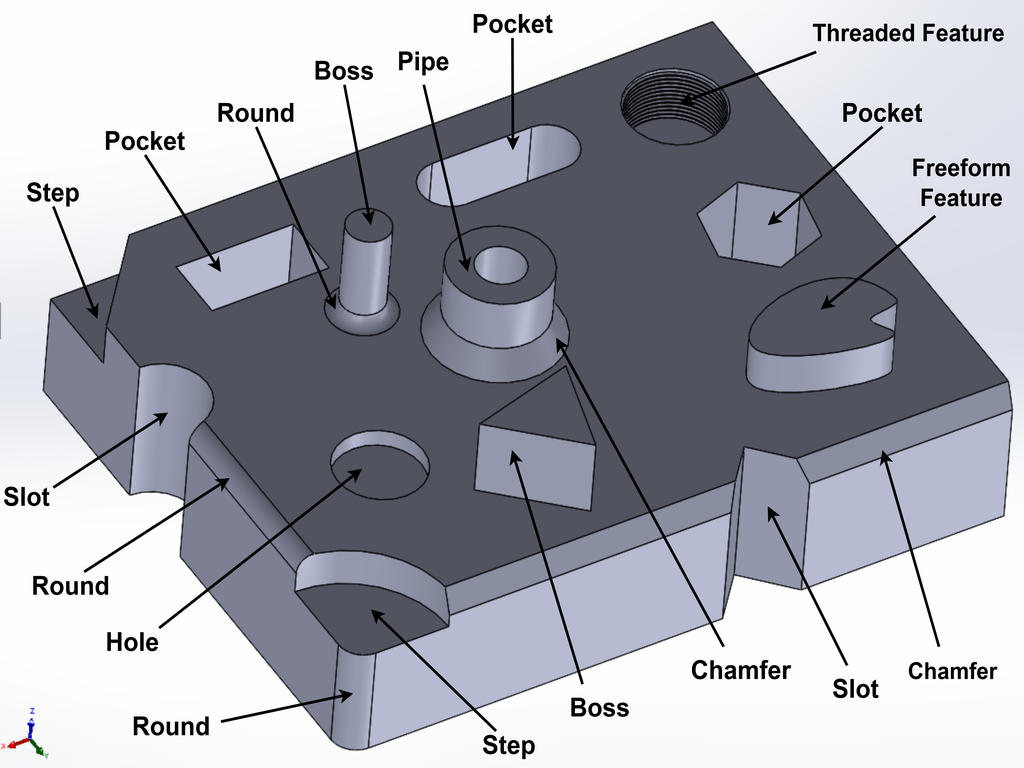

In [50]:
few_shot_examples[2]

reference: https://huggingface.co/docs/transformers/main/en/model_doc/llava_next#multi-image-inference

In [59]:
# Iterate through test cases and generate responses
for test_case, img in concatenated_images.items():
    # Prepare messages for feature recognition
    msgs_feature = llava_hf_mistral_processor(text=prompt_feature_recognition_5, images=[few_shot_examples[2], img], padding=True, return_tensors="pt").to("cuda:0")
    
    # autoregressively complete prompt
    output = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=4096)
    res_feature = llava_hf_mistral_processor.decode(output[0], skip_special_tokens=True)

    # generate_ids = llava_hf_mistral_model.generate(**msgs_feature, max_new_tokens=120)
    # res_feature = llava_hf_mistral_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    print (type(res_feature))
    print(f"\nFeature Recognition Result for {test_case}: \n\n {res_feature}")

    # Post-process response to filter out non-existent features
    consolidated_response = post_process_response(res_feature)
    
    print(f"\nFinal Feature Recognition Result for {test_case}: \n\n {consolidated_response}")
    
    # Save consolidated response to JSON file
    json_filename = os.path.join(output_dir, f"Llava_v1_6_mistral_7b_{test_case}_features.json")
    save_response_to_json(consolidated_response, json_filename)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_2: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hier

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_13: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_18: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_19: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_20: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_21: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_22: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_23: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_24: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_25: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_26: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_27: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_28: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_29: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_30: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_31: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_32: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for easy_33: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_9: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_12: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_21: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_22: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_23: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_24: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_25: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_26: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_27: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_28: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_29: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_30: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_31: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_32: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for medium_33: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_6: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hier

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_11: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_13: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_16: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_17: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_18: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_19: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_20: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_21: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_22: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_23: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_24: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_25: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_26: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_27: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_28: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_29: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_30: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_31: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_32: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<class 'str'>

Feature Recognition Result for hard_33: 

 
### Example Task:
[INST]  

This is an example image that shows you various features in a CAD model. Describe it with concise words, and use this reasoning to answer subsequent questions.
[/INST]

[INST]  

You are provided with images containing multiple views of a 3D CAD model taken from different angles. Your task is to identify and describe the manufacturing features present in these images. Refer to the provided list of feature names below, delimited by triple backticks, and strictly follow the naming conventions:

'''[{'name': 'Hole (Through / Blind Hole)', 'hierarchy': 'Machining Features > Hole (Through / Blind Hole)'}, {'name': 'Slot (Through / Blind / T-Slot / Dovetail)', 'hierarchy': 'Machining Features > Slot (Through / Blind / T-Slot / Dovetail)'}, {'name': 'Step (Through / Blind Step)', 'hierarchy': 'Machining Features > Step (Through / Blind Step)'}, {'name': 'Pocket (Blind / Through / Circular End Pocket)', 'hie